In [1]:
import os
import numpy as np
from numpy.lib.function_base import disp
import torch
import decord
from PIL import Image
from torchvision import transforms
from random_erasing import RandomErasing
import warnings
from decord import VideoReader, cpu
from torch.utils.data import Dataset
import video_transforms as video_transforms 
import volume_transforms as volume_transforms
from kinetics import *

class VideoClsDataset(Dataset):
    """Load your own video classification dataset."""

    def __init__(self, anno_path, data_path, mode='train', clip_len=8,
                 frame_sample_rate=2, crop_size=224, short_side_size=256,
                 new_height=256, new_width=340, keep_aspect_ratio=True,
                 num_segment=1, num_crop=1, test_num_segment=10, test_num_crop=3,args=None):
        self.anno_path = anno_path
        self.mode = mode
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.crop_size = crop_size
        self.short_side_size = short_side_size
        self.new_height = new_height
        self.new_width = new_width
        self.keep_aspect_ratio = keep_aspect_ratio
        self.num_segment = num_segment
        self.test_num_segment = test_num_segment
        self.num_crop = num_crop
        self.test_num_crop = test_num_crop
        self.args = args
        self.aug = False
        self.rand_erase = False
        if self.mode in ['train']:
            self.aug = True
            if self.args.reprob > 0:
                self.rand_erase = True
        if VideoReader is None:
            raise ImportError("Unable to import `decord` which is required to read videos.")

        import pandas as pd
        cleaned = pd.read_csv(self.anno_path, header=None, delimiter='   ')
        self.dataset_samples = list(cleaned.values[:, 0])
        self.label_array = list(cleaned.values[:, 1])

        if (mode == 'train'):
            pass

        elif (mode == 'validation'):
            self.data_transform = video_transforms.Compose([
                video_transforms.Resize((self.short_side_size,self.short_side_size), interpolation='bilinear'),
                video_transforms.CenterCrop(size=(self.crop_size, self.crop_size)),
                volume_transforms.ClipToTensor(),
                video_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])
            ])
        elif mode == 'test':
            self.data_resize = video_transforms.Compose([
                video_transforms.Resize(size=(self.short_side_size,self.short_side_size), interpolation='bilinear')
            ])
            self.data_transform = video_transforms.Compose([
                volume_transforms.ClipToTensor(),
                video_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225])
            ])
            self.test_seg = []
            self.test_dataset = []
            self.test_label_array = []
            for ck in range(self.test_num_segment):
                for cp in range(self.test_num_crop):
                    for idx in range(len(self.label_array)):
                        sample_label = self.label_array[idx]
                        self.test_label_array.append(sample_label)
                        self.test_dataset.append(self.dataset_samples[idx])
                        self.test_seg.append((ck, cp))

    def __getitem__(self, index):
        if self.mode == 'train':
            args = self.args 
            scale_t = 1

            sample = self.dataset_samples[index]
            buffer = self.loadvideo_decord(sample, sample_rate_scale=scale_t) # T H W C
            if len(buffer) == 0:
                while len(buffer) == 0:
                    warnings.warn("video {} not correctly loaded during training".format(sample))
                    index = np.random.randint(self.__len__())
                    sample = self.dataset_samples[index]
                    buffer = self.loadvideo_decord(sample, sample_rate_scale=scale_t)

            if args.num_sample > 1:
                frame_list = []
                label_list = []
                index_list = []
                for _ in range(args.num_sample):
                    new_frames = self._aug_frame(buffer, args)
                    label = self.label_array[index]
                    frame_list.append(new_frames)
                    label_list.append(label)
                    index_list.append(index)
                return frame_list, label_list, index_list, {}
            else:
                buffer = self._aug_frame(buffer, args)
            
            return buffer, self.label_array[index], index, {}

        elif self.mode == 'validation':
            sample = self.dataset_samples[index]
            buffer = self.loadvideo_decord(sample)
            if len(buffer) == 0:
                while len(buffer) == 0:
                    warnings.warn("video {} not correctly loaded during validation".format(sample))
                    index = np.random.randint(self.__len__())
                    sample = self.dataset_samples[index]
                    buffer = self.loadvideo_decord(sample)
            buffer = self.data_transform(buffer)
            return buffer, self.label_array[index], sample.split("/")[-1].split(".")[0]

        elif self.mode == 'test':
            sample = self.test_dataset[index]
            chunk_nb, split_nb = self.test_seg[index]
            buffer = self.loadvideo_decord(sample)

            while len(buffer) == 0:
                warnings.warn("video {}, temporal {}, spatial {} not found during testing".format(\
                    str(self.test_dataset[index]), chunk_nb, split_nb))
                index = np.random.randint(self.__len__())
                sample = self.test_dataset[index]
                chunk_nb, split_nb = self.test_seg[index]
                buffer = self.loadvideo_decord(sample)

            buffer = self.data_resize(buffer)
            if isinstance(buffer, list):
                buffer = np.stack(buffer, 0)
                
            if self.test_num_segment>1:
                temporal_step = max(1.0 * (buffer.shape[0] - self.clip_len) \
                                    / (self.test_num_segment - 1), 0)
                temporal_start = int(chunk_nb * temporal_step)
                buffer = buffer[temporal_start:temporal_start + self.clip_len, \
                        :, :, :]
            else:
                temporal_step = buffer.shape[0]//self.clip_len
                buffer = buffer[::temporal_step, \
                        :, :, :]

            buffer = self.data_transform(buffer)
            return buffer, self.test_label_array[index], sample.split("/")[-1].split(".")[0], \
                   chunk_nb, split_nb
        else:
            raise NameError('mode {} unkown'.format(self.mode))

    def _aug_frame(
        self,
        buffer,
        args,
    ):

        aug_transform = video_transforms.create_random_augment(
            input_size=(self.crop_size, self.crop_size),
            auto_augment=args.aa,
            interpolation=args.train_interpolation,
        )

        buffer = [
            transforms.ToPILImage()(frame) for frame in buffer
        ]

        buffer = aug_transform(buffer)

        buffer = [transforms.ToTensor()(img) for img in buffer]
        buffer = torch.stack(buffer) # T C H W
        buffer = buffer.permute(0, 2, 3, 1) # T H W C 
        
        # T H W C 
        buffer = tensor_normalize(
            buffer, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        )
        # T H W C -> C T H W.
        buffer = buffer.permute(3, 0, 1, 2)
        # Perform data augmentation.
        scl, asp = (
            [0.08, 1.0],
            [0.75, 1.3333],
        )

        buffer = spatial_sampling(
            buffer,
            spatial_idx=-1,
            min_scale=256,
            max_scale=320,
            crop_size=self.crop_size,
            random_horizontal_flip=False if args.data_set == 'SSV2' else True ,
            inverse_uniform_sampling=False,
            aspect_ratio=asp,
            scale=scl,
            motion_shift=False
        )

        if self.rand_erase:
            erase_transform = RandomErasing(
                args.reprob,
                mode=args.remode,
                max_count=args.recount,
                num_splits=args.recount,
                device="cpu",
            )
            buffer = buffer.permute(1, 0, 2, 3)
            buffer = erase_transform(buffer)
            buffer = buffer.permute(1, 0, 2, 3)

        return buffer


    def loadvideo_decord(self, sample, sample_rate_scale=1):
        """Load video content using Decord"""
        fname = sample

        if not (os.path.exists(fname)):
            return []

        # avoid hanging issue
        if os.path.getsize(fname) < 1 * 1024:
            print('SKIP: ', fname, " - ", os.path.getsize(fname))
            return []
        try:
            if self.keep_aspect_ratio:
                vr = VideoReader(fname, num_threads=1, ctx=cpu(0))
            else:
                vr = VideoReader(fname, width=self.new_width, height=self.new_height,
                                 num_threads=1, ctx=cpu(0))
        except:
            print("video cannot be loaded by decord: ", fname)
            return []

        if self.mode == 'test':
            all_index = [x for x in range(0, len(vr), self.frame_sample_rate)]
            while len(all_index) < self.clip_len:
                all_index.append(all_index[-1])
            vr.seek(0)
            buffer = vr.get_batch(all_index).asnumpy()
            return buffer

        # handle temporal segments
        converted_len = int(self.clip_len * self.frame_sample_rate)
        seg_len = len(vr) // self.num_segment

        all_index = []
        for i in range(self.num_segment):
            if seg_len <= converted_len:
                index = np.linspace(0, seg_len, num=seg_len // self.frame_sample_rate)
                index = np.concatenate((index, np.ones(self.clip_len - seg_len // self.frame_sample_rate) * seg_len))
                index = np.clip(index, 0, seg_len - 1).astype(np.int64)
            else:
                end_idx = np.random.randint(converted_len, seg_len)
                str_idx = end_idx - converted_len
                index = np.linspace(str_idx, end_idx, num=self.clip_len)
                index = np.clip(index, str_idx, end_idx - 1).astype(np.int64)
            index = index + i*seg_len
            all_index.extend(list(index))

        all_index = all_index[::int(sample_rate_scale)]
        vr.seek(0)
        buffer = vr.get_batch(all_index).asnumpy()
        return buffer

    def __len__(self):
        if self.mode != 'test':
            return len(self.dataset_samples)
        else:
            return len(self.test_dataset)

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import pickle
import neptune

from itertools import product
import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
import itertools
import itertools
import pandas as pd
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

C:\Users\User\AppData\Local\Temp\ipykernel_13244\3683968895.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
model_ident = "MHEALTHvids_small_ae_classifier_1024_emb1d"
unique_iden = "epoch20_emb400"
dataset_ident = "HMDB51"

main_dir = "../.."
data_dir = os.path.join("D:\\FYP\\hmdb51_org")

epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
prototypes_save = os.path.join(main_dir,"prototypes")
test_vids = os.path.join(main_dir,"test_vids")
setting_fol = os.path.join(main_dir,"settings")
os.makedirs(f"{setting_fol}/{model_ident}",exist_ok=True)
train_ratio = 0.90
val_ratio = 0.1
batch_size = 4



train_file_list = {k:random.sample(os.listdir(os.path.join(data_dir,k)),int(train_ratio*len(os.listdir(os.path.join(data_dir,k))))) for k in os.listdir(data_dir)}
val_file_list = {k:[x for x in os.listdir(os.path.join(data_dir,k)) if x not in train_file_list[k]] for k in os.listdir(data_dir)}

train_items = []
val_items = []
for k in train_file_list.keys():
  train_items.extend(itertools.product([k],train_file_list[k]))
  
for k in val_file_list.keys():
  val_items.extend(itertools.product([k],val_file_list[k]))

val_items = [f"{data_dir}/{item[0]}/{item[1]}   {item[0]}" for item in val_items]
train_items = [f"{data_dir}/{item[0]}/{item[1]}   {item[0]}" for item in train_items]

random.shuffle(val_items)
random.shuffle(train_items)

with open(f"{setting_fol}/{model_ident}/{dataset_ident}_train_setings.txt","w") as f0:
  f0.write("\n".join(train_items))

with open(f"{setting_fol}/{model_ident}/{dataset_ident}_val_setings.txt","w") as f0:
  f0.write("\n".join(val_items))

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

class_names = os.listdir(data_dir)

In [4]:
len(train_items),len(val_items)

(6066, 700)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

id2clsname, clsname2id = classname_id(class_names)

In [6]:
test_mode = True
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]




train_dataset = VideoClsDataset(
            anno_path=f"{setting_fol}/{model_ident}/{dataset_ident}_train_setings.txt",
            data_path='/',
            mode="test",
            clip_len=16,
            frame_sample_rate=10,
            num_segment=1,
            test_num_segment=1,
            test_num_crop=1,
            num_crop=1,
            keep_aspect_ratio=True,
            crop_size=224,
            short_side_size=224,
            new_height=256,
            new_width=320)

val_dataset = VideoClsDataset(
            anno_path=f"{setting_fol}/{model_ident}/{dataset_ident}_val_setings.txt",
            data_path='/',
            mode="test",
            clip_len=16,
            frame_sample_rate=10,
            num_segment=1,
            test_num_segment=1,
            test_num_crop=1,
            num_crop=1,
            keep_aspect_ratio=True,
            crop_size=224,
            short_side_size=224,
            new_height=256,
            new_width=320)

C:\Users\User\AppData\Local\Temp\ipykernel_13244\2766644159.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleaned = pd.read_csv(self.anno_path, header=None, delimiter='   ')
C:\Users\User\AppData\Local\Temp\ipykernel_13244\2766644159.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleaned = pd.read_csv(self.anno_path, header=None, delimiter='   ')


In [7]:
buffer, label, id, chunk_nb, split_nb = train_dataset[0]

In [16]:
files = os.listdir("F:\My Drive")

In [8]:
def save_data_numpy(save_path,i):
    video, label, id, chunk_nb, split_nb = train_dataset[i]
    
    np.savez_compressed(f"{save_path}/{label}_{id}_{chunk_nb}_{split_nb}.npz",
          video = video,
          label = label,
          id = id,
          chunk_nb = chunk_nb,
          split_nb = split_nb)

In [9]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

os.makedirs("D:/FYP/VideoMAE/preprocessed/HMDB51_1seg/train",exist_ok=True)
#for each_file in tqdm(files,desc="Files Used",total=len(files)):
with ThreadPoolExecutor() as executor:
    file_loc = list(
        tqdm(
            executor.map(
                partial(
                    save_data_numpy,
                    "D:/FYP/VideoMAE/preprocessed/HMDB51_1seg/train"),
                range(len(train_dataset))), 
            total=len(train_dataset),
            desc="Processed Files:"))

Processed Files::   0%|          | 0/6066 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
os.makedirs("D:/FYP/VideoMAE/preprocessed/HMDB51_1seg/val",exist_ok=True)
#for each_file in tqdm(files,desc="Files Used",total=len(files)):
with ThreadPoolExecutor() as executor:
    file_loc = list(
        tqdm(
            executor.map(
                partial(
                    save_data_numpy,
                    "D:/FYP/VideoMAE/preprocessed/HMDB51_1seg/val"),
                range(len(val_dataset))), 
            total=len(val_dataset),
            desc="Processed Files:"))



Processed Files::   0%|          | 0/700 [00:00<?, ?it/s]

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [ ]:
random.sample(os.listdir("D:/FYP/VideoMAE/preprocessed/HMDB51_1seg/val"),10)

['jump_THE_PROTECTOR_jump_f_nm_np1_ba_bad_64_0_0.npz',
 'cartwheel_Cartwheel_Competition_cartwheel_f_cm_np1_ri_med_5_0_0.npz',
 'ride_bike_Fahrrad_fahren_mit_Albert_ride_bike_f_cm_np1_ba_med_0_0_0.npz',
 'smoke_smoking_a_cigarette_smoke_h_nm_np1_fr_med_1_0_0.npz',
 'push_Pushing_Music_Table_push_f_cm_np1_ba_bad_0_0_0.npz',
 'climb_stairs_Intense_Cardio_Session-_Stairs_climb_stairs_f_cm_np1_ba_med_0_0_0.npz',
 'shake_hands_Meet_shake_hands_u_cm_np2_le_med_0_0_0.npz',
 'dribble_Basketball_Training-_Amazing_3_ball_and_4_ball_dribbling_dribble_f_cm_np1_fr_bad_1_0_0.npz',
 'dive_Pirates_5_dive_f_cm_np1_ba_bad_0_0_0.npz',
 'climb_DM_Sportklettern_2006-_Finale_Herren_-_Markus_Hoppe_climb_f_cm_np1_ri_med_0_0_0.npz']

In [ ]:
arrays = np.load('D:/FYP/VideoMAE/preprocessed/HMDB51/val/pushup_Chris_Comfort_s_Push_Up_Workout_Part_I_pushup_f_nm_np1_ri_goo_1_0_0.npz',)
video = arrays["video"]
label = arrays["label"]
id = arrays["id"]

print("Label:- ",label,"ID:- " ,id)
display_gif(torch.from_numpy(video),gif_name=f"{id}.gif")

FileNotFoundError: [Errno 2] No such file or directory: 'D:/FYP/VideoMAE/preprocessed/HMDB51/val/pushup_Chris_Comfort_s_Push_Up_Workout_Part_I_pushup_f_nm_np1_ri_goo_1_0_0.npz'

Label:-  somersault ID:-  Parkour_Dive_Tutorial_somersault_f_cm_np1_fr_bad_2


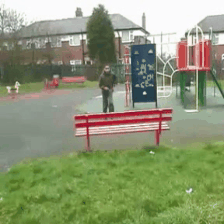

In [ ]:
arrays = np.load('D:/FYP/VideoMAE/preprocessed/HMDB51/val/somersault_Parkour_Dive_Tutorial_somersault_f_cm_np1_fr_bad_2_0_0.npz')
video = arrays["video"]
label = arrays["label"]
id = arrays["id"]

print("Label:- ",label,"ID:- " ,id)
display_gif(torch.from_numpy(video),gif_name=f"{id}.gif")

Label:-  kick ID:-  THE_PROTECTOR_kick_f_cm_np1_le_med_43


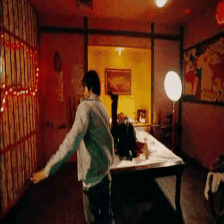

In [ ]:
arrays = np.load('D:/FYP/VideoMAE/preprocessed/HMDB51/val/kick_THE_PROTECTOR_kick_f_cm_np1_le_med_43_0_0.npz')
video = arrays["video"]
label = arrays["label"]
id = arrays["id"]

print("Label:- ",label,"ID:- " ,id)
display_gif(torch.from_numpy(video),gif_name=f"{id}.gif")

Label:-  shoot_gun ID:-  The_Matrix_5_shoot_gun_u_cm_np1_fr_goo_2


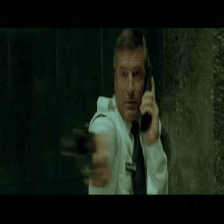

In [ ]:
arrays = np.load('D:/FYP/VideoMAE/preprocessed/HMDB51/val/shoot_gun_The_Matrix_5_shoot_gun_u_cm_np1_fr_goo_2_0_0.npz')
video = arrays["video"]
label = arrays["label"]
id = arrays["id"]

print("Label:- ",label,"ID:- " ,id)
display_gif(torch.from_numpy(video),gif_name=f"{id}.gif")